# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [38]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
tidal_df = pd.read_csv('data/tidal_wetland_estuaries.csv')
tidal_df.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


In [40]:
tidal_df.columns

Index(['name', 'coast', 'estu_latitude', 'estu_longintude', 'estu_dep',
       'estu_perim', 'land_area', 'land_latitude', 'land_longitude',
       'population', 'tide_ht', 'estu_salinity', 'ocean_salinity_mean',
       'air_temp_mean', 'frost_days_per_yr', 'ocean_sst_mean',
       'ocean_diss_inorg_p', 'ocean_no3', 'tide_flow', 'mean_precip',
       'mean_temp', 'soc_density'],
      dtype='object')

In [41]:
east_df = tidal_df.loc[tidal_df['coast']=='EAST',:]
west_df = tidal_df.loc[tidal_df['coast']=='WEST',:]

stats.ttest_ind(east_df['soc_density'], west_df['soc_density'], alternative='greater', nan_policy='omit')



Ttest_indResult(statistic=8.450317786693118, pvalue=5.765284478012782e-13)

Interpertation: we found through a 2-sample t-test of the means of the soc_density of the east coast vs. west coast that the t-statistic = 8.450317786693118 and the p-value = 5.765284478012782e-13. The t-statistic tells us that the is a large difference between the means of the two groups. The p-value indicates strong vidence against the null hypotheesis and because it's smaller than the threshold of 0.05, we can safly reject the null hypothesis and accept the alternative hypothesis which is that the soil carbon density oon the east coast is largeer than that on the west coast.
<br />
<br />
I used the two-sample t-test because we are comparing the means of two groups of data are different from eachother. The one-sample t-test should be used for determining if the mean of one group is different from one value. Since we are not comparing data for the same subject, it's not appropriote to use paired sample t test either.
<br />
<br />
To see if the data is normally distributed, I plotted histograms for east_df and west_df. We can see that visually, they look fairly normally distributed. For both data groups, the mean, median and mode are approximately equal and also the Shapiro-Wilk Test results show that the p-value > 0.05 which means we are rejcting the alternative hypotheesis that the data re not normally distributed and accept the null hypothesis that they are.

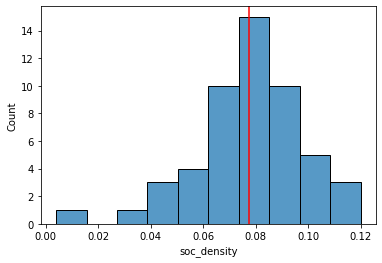

mean= 0.07757692307692311
median= 0.077
mode= 0.07
Shapiro-Wilk Test= ShapiroResult(statistic=0.9622166752815247, pvalue=0.09766162186861038)


<ipython-input-42-6f4b675f39ce>:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("mode= " + str(stats.mode(east_df['soc_density'])[0][0]))


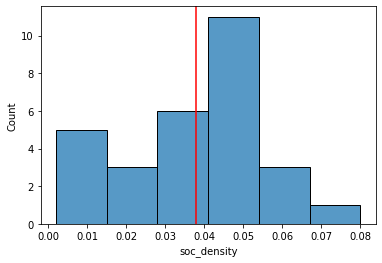

mean= 0.03779310344827588
median= 0.044000000000000004
mode= 0.034
Shapiro-Wilk Test= ShapiroResult(statistic=0.9360842704772949, pvalue=0.0792006105184555)


<ipython-input-42-6f4b675f39ce>:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("mode= " + str(stats.mode(west_df['soc_density'])[0][0]))


In [42]:
sns.histplot(east_df['soc_density'])
plt.axvline(x=np.mean(east_df['soc_density']), color="red")
plt.show()

print("mean= " + str(np.mean(east_df['soc_density'])))
print("median= " + str(np.median(east_df['soc_density'])))
print("mode= " + str(stats.mode(east_df['soc_density'])[0][0]))
print("Shapiro-Wilk Test= " + str(stats.shapiro(east_df['soc_density'])))

sns.histplot(west_df['soc_density'])
plt.axvline(x=np.mean(west_df['soc_density']), color="red")
plt.show()

print("mean= " + str(np.mean(west_df['soc_density'])))
print("median= " + str(np.median(west_df['soc_density'])))
print("mode= " + str(stats.mode(west_df['soc_density'])[0][0]))
print("Shapiro-Wilk Test= " + str(stats.shapiro(west_df['soc_density'])))

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

In [51]:
from utils import Linear_Reg_Diagnostic # do not change!
import statsmodels.formula.api as smf

tidal_df = tidal_df.replace(-9999, np.nan)

model = smf.ols(formula='ocean_salinity_mean ~ mean_precip  + land_latitude + air_temp_mean + ocean_sst_mean',data=tidal_df).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.843
Model:                             OLS   Adj. R-squared:                  0.837
Method:                  Least Squares   F-statistic:                     146.4
Date:                 Mon, 24 Apr 2023   Prob (F-statistic):           6.97e-43
Time:                         18:14:55   Log-Likelihood:                -111.80
No. Observations:                  114   AIC:                             233.6
Df Residuals:                      109   BIC:                             247.3
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         38.4141      2.180     17.625      0.000      34.094      42.734
mean_precip       -0.0008      0.000     -4.543      0.000      -0.001      -0.000
land_latitude     -0.1389      0.043     -3.202      0.002      -0.225      -0.053
air_temp_mean     -0.3613      0.070     -5.141      0.000      -0.501      -0.222
ocean_sst_mean     0.3871      0.049      7.921      0.000       0.290       0.484
==============================================================================
Omnibus:                       14.014   Durbin-Watson:                   0.409
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.284
Skew:                          -0.798   Prob(JB):                     0.000480
Kurtosis:                       3.818   Cond. No.                     4.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interpertation:
<br />
<br />
This model has an R-squared value of 0.843 which means that about 84% of the variation in the ocean_salinity_mean is expllained by the indepedent variables. It does this by summing up all the squares of the differences between the actual value and the predicted value (residuals) and diving it by the total sum of squares. This essentially telling you how close the actual data are to the fitted line which indicates how "good of a fit" the line is. So in this ccase, it means the model is "84% good or accurate"
<br />
<br />
For the coefficients, I found that it works when I use the mean_precip, land_latitude, air_temp_mean, and ocean_sst_mean. These all have significance in the final prediction (p < 0.05) which means that they all have a significant weight in determining the ocean_salinity_mean.

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

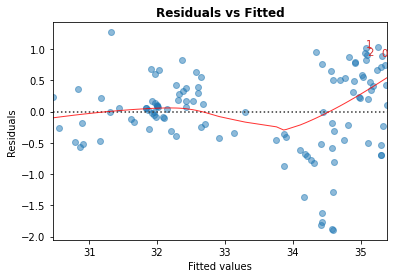

In [52]:
diagnostics = Linear_Reg_Diagnostic(model)
diagnostics.residual_plot()

There is generally a horizontal line, and for each oof the fitted values, there's a pretty equal spread above and below the line. Except for around 34.

<AxesSubplot:title={'center':'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

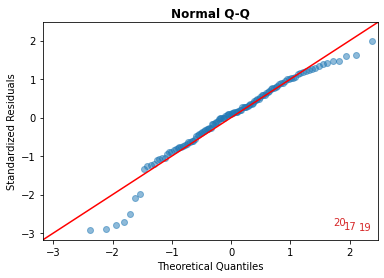

In [53]:
diagnostics.qq_plot()

The points generally fall on the one to one lline which means they're pretty normally distributed.

<AxesSubplot:title={'center':'Scale-Location'}, xlabel='Fitted values', ylabel='$\\sqrt{|\\mathrm{Standardized\\ Residuals}|}$'>

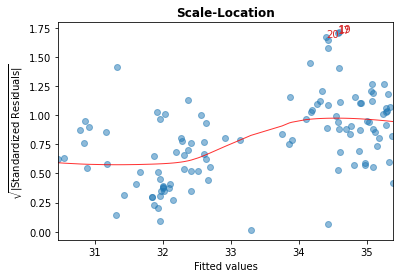

In [54]:
diagnostics.scale_location_plot()

Again, here we can see that generally there is a horizontal line with an even spread of data above and below the line

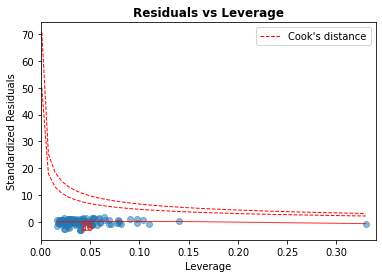

In [55]:
diagnostics.leverage_plot();

Most of the data is clustered in the same place. There is one point way oon the right that might be mroe of an outlier. We could remove it and see if that improves the R-squared.

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

In [14]:
coal_df = pd.read_csv('data/coal-production.csv')
coal_df.head()

,year,electricity_prod
0,1960,45.904345
1,1961,45.730794
2,1962,46.411172
3,1963,46.599523
4,1964,46.102588


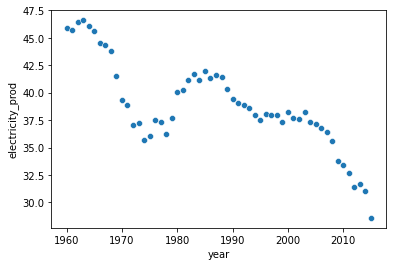

In [15]:
sns.scatterplot(data=coal_df, x='year', y='electricity_prod' )
plt.show()

In [16]:
#Preprocess data to set the correct datetime type

coal_df['year'] = pd.to_datetime(coal_df['year'], format='%Y')
coal_df = coal_df.set_index('year').sort_index() # makes sure years are in order
coal_df.head()

,electricity_prod
year,
1960-01-01,45.904345
1961-01-01,45.730794
1962-01-01,46.411172
1963-01-01,46.599523
1964-01-01,46.102588


Text(0, 0.5, 'Elec Prod')

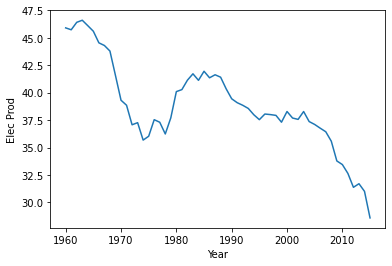

In [17]:
#find a trend in the data

fig, ax = plt.subplots()
ax.plot(coal_df['electricity_prod'])
ax.set_xlabel('Year')
ax.set_ylabel('Elec Prod')

Data seems to have a negative trend

In [18]:
#Test for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(coal_df)


ADF Statistic: 1.8721544326758204
p-value: 0.9984818799941668


The p-value is large, so that meeans the data is not stationary

In [19]:
#ARIMA Model

from scipy.stats import pearsonr

lag = 1 # how many years removed?

# current year
electricity_prod_t = coal_df['electricity_prod'][:len(coal_df)-lag]

# one year prior
electricity_prod_t1 = coal_df['electricity_prod'][lag:]

# calcualte correlation
r, p = pearsonr(electricity_prod_t, electricity_prod_t1)
print('correlation:', r)
print('p-value:', p)

correlation: 0.9724865476622064
p-value: 3.2751806396618266e-35


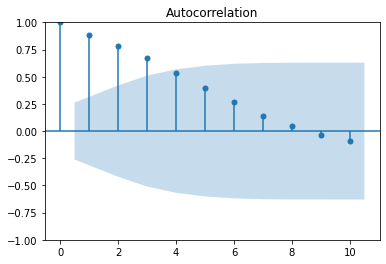

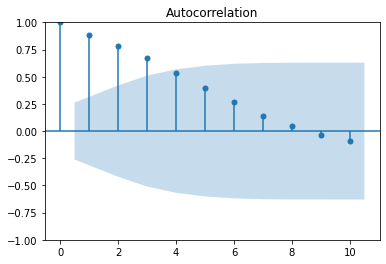

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(coal_df, lags=10)

### AR Model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       electricity_prod   No. Observations:                   55
Model:                     AutoReg(4)   Log Likelihood                 -64.447
Method:               Conditional MLE   S.D. of innovations              0.856
Date:                Mon, 24 Apr 2023   AIC                            140.893
Time:                        16:52:26   BIC                            152.484
Sample:                    01-01-1965   HQIC                           145.323
                         - 01-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1798      0.134     -1.344      0.179      -0.442       0.082
electricity_prod.L1     0.1655      0.145      1.139      0.255      -0.119       0.450
electricity_prod.L2     0.0025      0.141      0.018      0.986      -0.273       0.279
electricity_prod.L3     0.3397      0.141      2.409      0.016       0.063       0.616
electricity_prod.L4     0.0643      0.147      0.437      0.662      -0.224       0.352
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2360           -0.0000j            1.2360           -0.0000
AR.2           -0.5306           -1.4226j            1.5183           -0.3068
AR.3           -0.5306           +1.4226j            1.5183            0.3068
AR.4           -5.4587           -0.0000j            5.4587           -0.5000
-----------------------------------------------------------------------------
"""

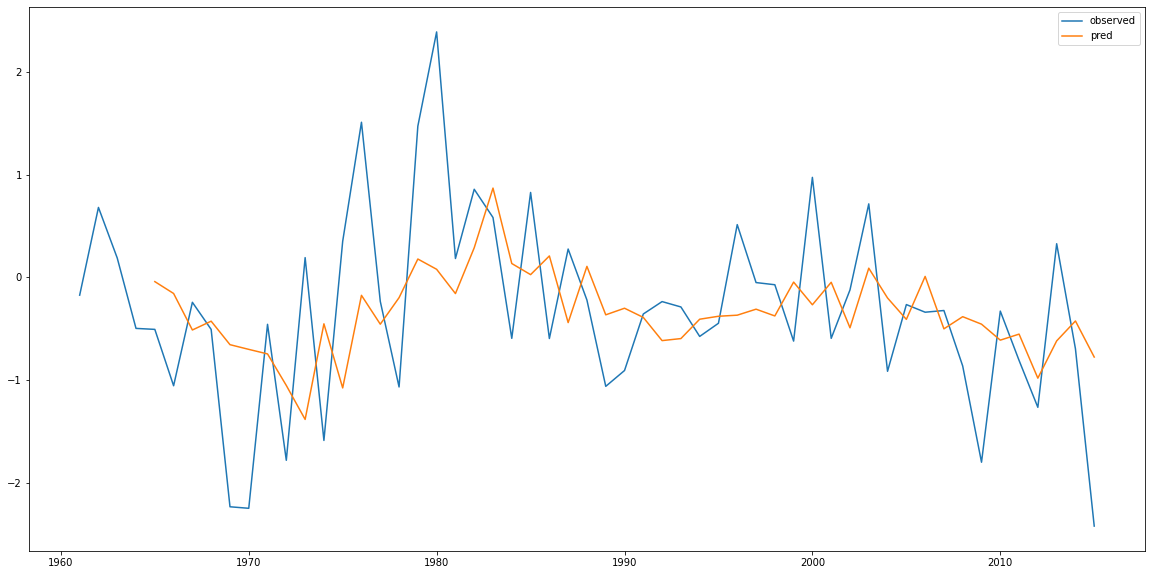

In [21]:
from statsmodels.tsa.ar_model import AutoReg

y_diff = coal_df['electricity_prod'].diff().dropna()

ar_model = AutoReg(y_diff, lags=4).fit()
y_pred = ar_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(y_pred, label='pred')
ax.legend()
ar_model.summary()

### MA Model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       electricity_prod   No. Observations:                   55
Model:                 ARIMA(0, 0, 4)   Log Likelihood                 -67.885
Date:                Mon, 24 Apr 2023   AIC                            147.771
Time:                        16:52:29   BIC                            159.815
Sample:                    01-01-1961   HQIC                           152.429
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3163      0.183     -1.731      0.083      -0.675       0.042
ma.L1          0.0872      0.157      0.554      0.579      -0.221       0.395
ma.L2         -0.1065      0.130     -0.821      0.4

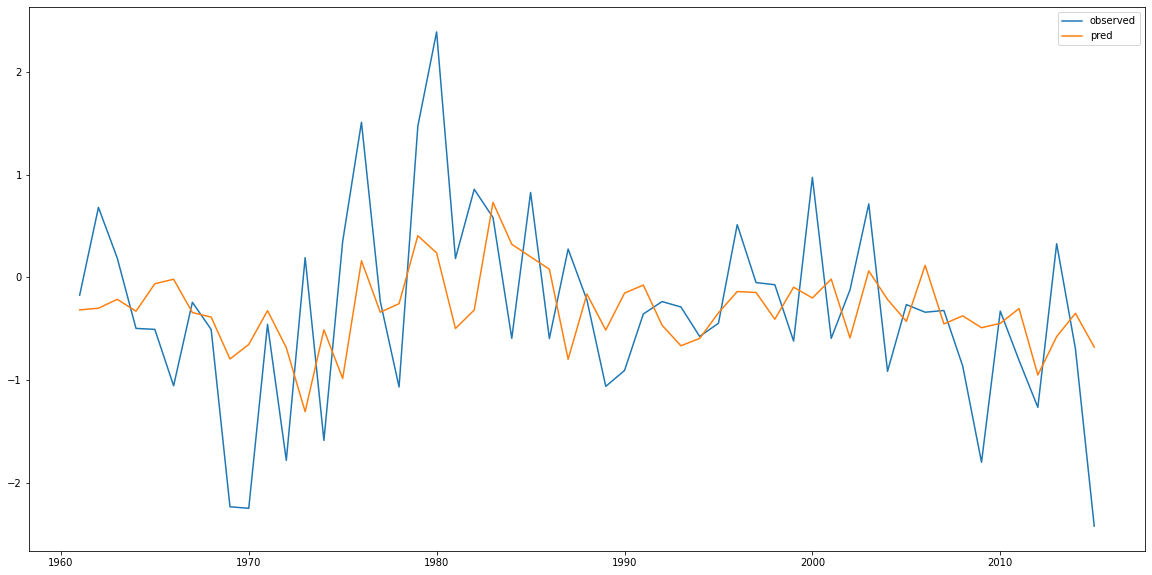

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an MA(2) model to the first simulated data
ma_model = ARIMA(y_diff, order=(0,0,4)).fit()
y_pred = ma_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(y_pred, label='pred')
ax.legend()
# Print out summary information on the fit
print(ma_model.summary())

### Both AR and MA Model

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible start

                               SARIMAX Results                                
Dep. Variable:       electricity_prod   No. Observations:                   55
Model:                 ARIMA(0, 0, 4)   Log Likelihood                 -67.885
Date:                Mon, 24 Apr 2023   AIC                            147.771
Time:                        16:52:31   BIC                            159.815
Sample:                    01-01-1961   HQIC                           152.429
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3163      0.183     -1.731      0.083      -0.675       0.042
ma.L1          0.0872      0.157      0.554      0.579      -0.221       0.395
ma.L2         -0.1065      0.130     -0.821      0.4

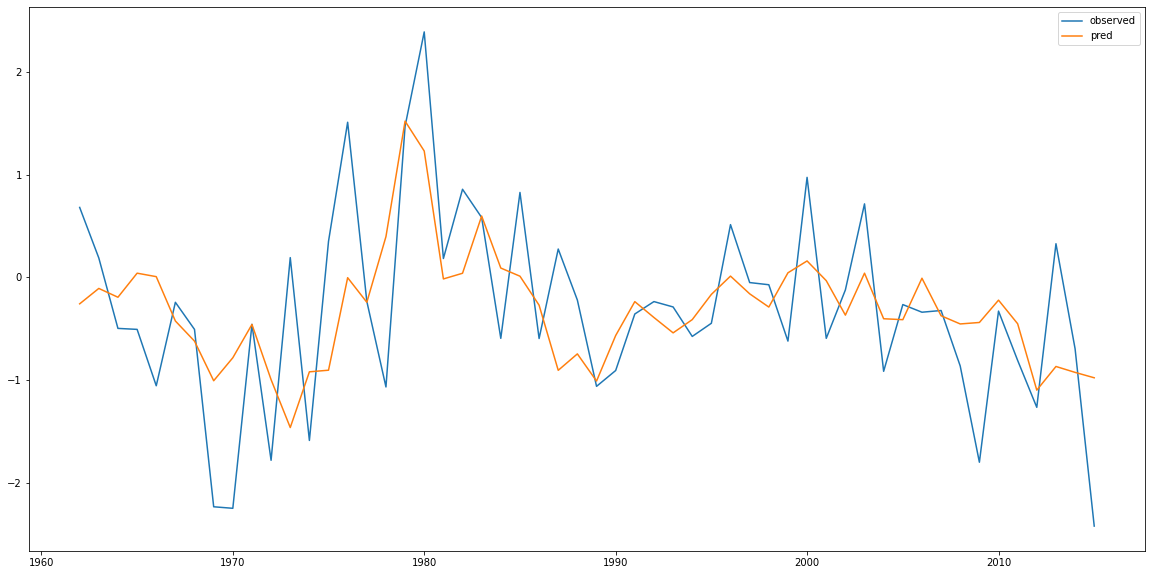

In [23]:
mod = ARIMA(y_diff, order=(4, 0, 2))
arma_model = mod.fit()

y_pred = arma_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff[1:], label='observed')
ax.plot(y_pred[1:], label='pred')
ax.legend()

print(ma_model.summary())

We can see that using 1, 2, 3, and 4 lags gives a significant correlation. When I manually changed the lag values, I found this to also be the case

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       electricity_prod   No. Observations:                   55
Model:                 ARIMA(0, 0, 4)   Log Likelihood                 -67.885
Date:                Mon, 24 Apr 2023   AIC                            147.771
Time:                        16:52:33   BIC                            159.815
Sample:                    01-01-1961   HQIC                           152.429
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3163      0.183     -1.731      0.083      -0.675       0.042
ma.L1          0.0872      0.157      0.554      0.579      -0.221       0.395
ma.L2         -0.1065      0.130     -0.821      0.4

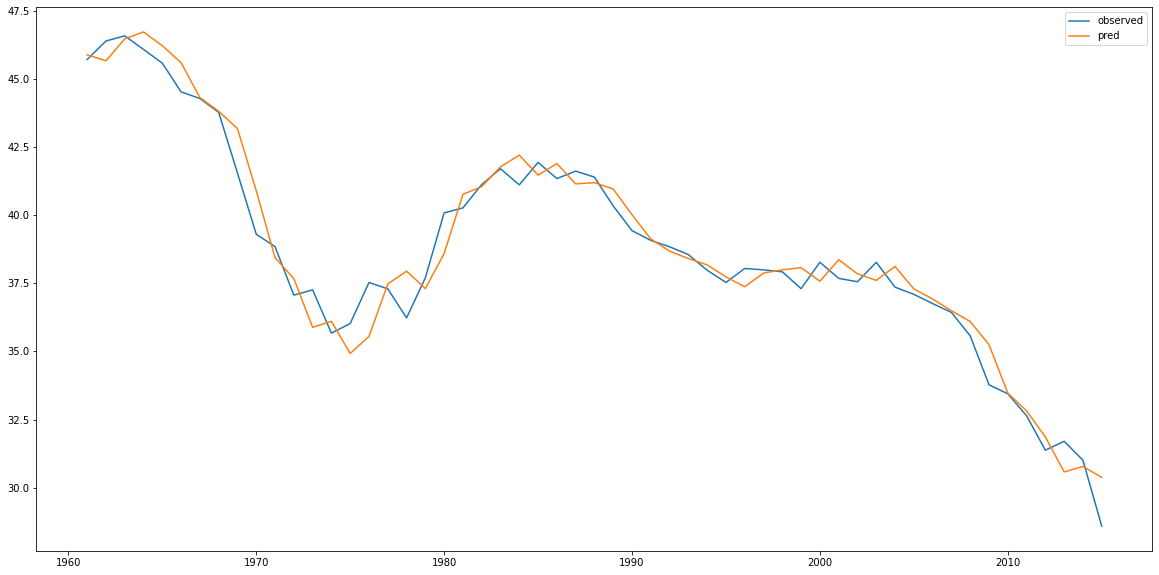

In [24]:
# Making the ARIMA Model

from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(coal_df['electricity_prod'], order=(3, 1, 2))
arima_model = mod.fit()

y_pred = arima_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(coal_df['electricity_prod'][1:], label='observed')
ax.plot(y_pred[1:], label='pred')
ax.legend()
print(ma_model.summary())

After trying different models, it looks like the ARIMA model is the best fit. It's also the most interpertable because it fits it to the actual values instead of the differenced ones

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


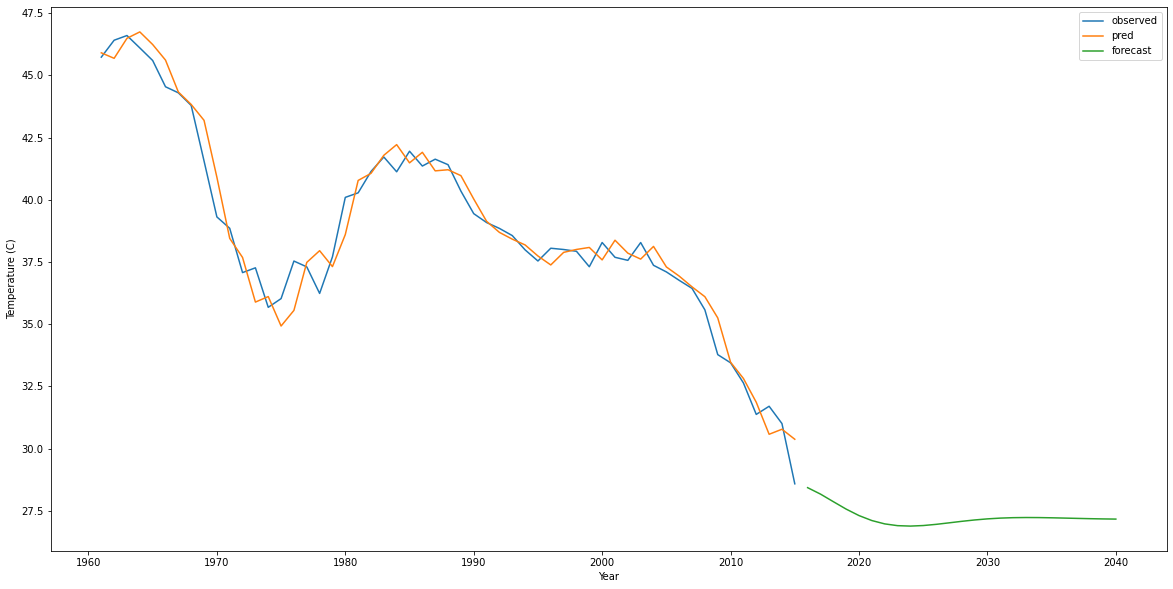

In [31]:
#Predicting
arima_model = ARIMA(coal_df, order=(3, 1, 2)).fit()
arima_forecast = arima_model.forecast(25, return_conf_interval=True)

fig, ax = plt.subplots(figsize=(20,10))

ax.plot(coal_df['electricity_prod'][1:], label='observed')
ax.plot(y_pred[1:], label='pred')
ax.plot(arima_forecast, label='forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (C)')
ax.legend()

In [56]:
# import pmdarima as pm
# model = pm.auto_arima(coal_df['electricity_prod'])
# model.summary()